In [5]:
import xarray as xr
from dask.diagnostics import ProgressBar
from xgcm import Grid
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

%matplotlib inline

In [6]:
datapath = '/srv/scratch/z3097808/20year_run/20year_freerun_output_NEWnci/'
ds = xr.open_mfdataset(datapath + 'outer_avg_014*.nc', chunks={'ocean_time': 100}, combine='by_coords', decode_coords=True)

# Creating a grid object
While xgcm doesn't currently have an implementation for the SGRID convention for ROMS, a workaround consist on renaming eta_u and xi_v dimensions to rho. With this replacement 'psi' points have now a position (eta_v, xi_u). See issue here https://github.com/xgcm/xgcm/issues/108

Here I also test to see if the new XGCM 'metrics' functionality works.

In [7]:
# Including metrics
ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}}

grid = Grid(ds, coords=coords, periodic=[])

Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = Zo_rho * (ds.zeta + ds.h) + ds.zeta
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')


ds['pm_v'] = grid.interp(ds.pm, 'Y')
ds['pn_u'] = grid.interp(ds.pn, 'X')
ds['pm_u'] = grid.interp(ds.pm, 'X')
ds['pn_v'] = grid.interp(ds.pn, 'Y')
ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

ds['dx'] = 1/ds.pm
ds['dx_u'] = 1/ds.pm_u
ds['dx_v'] = 1/ds.pm_v
ds['dx_psi'] = 1/ds.pm_psi

ds['dy'] = 1/ds.pn
ds['dy_u'] = 1/ds.pn_u
ds['dy_v'] = 1/ds.pn_v
ds['dy_psi'] = 1/ds.pn_psi

ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
ds['dz_u'] = grid.interp(ds.dz, 'X')
ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
ds['dz_v'] = grid.interp(ds.dz, 'Y')
ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

ds['dA'] = ds.dx * ds.dy

metrics = {
    ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
    ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
    ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
    ('X', 'Y'): ['dA'] # Areas
}
grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

/home/z3526974/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  from ipykernel import kernelapp as app
/home/z3526974/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  app.launch_new_instance()


In [8]:
ds

<xarray.Dataset>
Dimensions:      (Nuser: 25, boundary: 4, eta_rho: 317, eta_v: 316, ocean_time: 60, s_rho: 30, s_w: 31, tracer: 2, xi_rho: 272, xi_u: 271)
Coordinates:
    lat_rho      (eta_rho, xi_rho) float64 dask.array<chunksize=(317, 272), meta=np.ndarray>
    lon_rho      (eta_rho, xi_rho) float64 dask.array<chunksize=(317, 272), meta=np.ndarray>
    lon_u        (eta_rho, xi_u) float64 dask.array<chunksize=(317, 271), meta=np.ndarray>
    lon_v        (eta_v, xi_rho) float64 dask.array<chunksize=(316, 272), meta=np.ndarray>
    lon_psi      (eta_v, xi_u) float64 dask.array<chunksize=(316, 271), meta=np.ndarray>
    lat_u        (eta_rho, xi_u) float64 dask.array<chunksize=(317, 271), meta=np.ndarray>
    lat_psi      (eta_v, xi_u) float64 dask.array<chunksize=(316, 271), meta=np.ndarray>
    lat_v        (eta_v, xi_rho) float64 dask.array<chunksize=(316, 272), meta=np.ndarray>
  * s_rho        (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
  * s_w          (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.02161 -0.01 0.0
  * ocean_time   (ocean_time) datetime64[ns] 1994-01-01T12:00:00 ... 1994-03-01T12:00:00
    z_w          (ocean_time, s_w, eta_rho, xi_rho) float64 dask.array<chunksize=(30, 31, 317, 272), meta=np.ndarray>
    z_rho        (ocean_time, s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(30, 30, 317, 272), meta=np.ndarray>
Dimensions without coordinates: Nuser, boundary, eta_rho, eta_v, tracer, xi_rho, xi_u
Data variables:
    ntimes       (ocean_time) int32 8640 8640 8640 8640 ... 8640 8640 8640 8640
    ndtfast      (ocean_time) int32 35 35 35 35 35 35 35 ... 35 35 35 35 35 35
    dt           (ocean_time) float64 300.0 300.0 300.0 ... 300.0 300.0 300.0
    dtfast       (ocean_time) float64 8.571 8.571 8.571 ... 8.571 8.571 8.571
    dstart       (ocean_time) datetime64[ns] 1994-01-01 ... 1994-01-31
    nHIS         (ocean_time) int32 8640 8640 8640 8640 ... 8640 8640 8640 8640
    ndefHIS      (ocean_time) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    nRST         (ocean_time) int32 8640 8640 8640 8640 ... 8640 8640 8640 8640
    ntsAVG       (ocean_time) int32 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    nAVG         (ocean_time) int32 288 288 288 288 288 ... 288 288 288 288 288
    ndefAVG      (ocean_time) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    Falpha       (ocean_time) float64 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0
    Fbeta        (ocean_time) float64 4.0 4.0 4.0 4.0 4.0 ... 4.0 4.0 4.0 4.0
    Fgamma       (ocean_time) float64 0.284 0.284 0.284 ... 0.284 0.284 0.284
    nl_tnu2      (ocean_time, tracer) float64 dask.array<chunksize=(30, 2), meta=np.ndarray>
    nl_visc2     (ocean_time) float64 55.0 55.0 55.0 55.0 ... 55.0 55.0 55.0
    Akt_bak      (ocean_time, tracer) float64 dask.array<chunksize=(30, 2), meta=np.ndarray>
    Akv_bak      (ocean_time) float64 2e-05 2e-05 2e-05 ... 2e-05 2e-05 2e-05
    Akk_bak      (ocean_time) float64 5e-06 5e-06 5e-06 ... 5e-06 5e-06 5e-06
    Akp_bak      (ocean_time) float64 5e-06 5e-06 5e-06 ... 5e-06 5e-06 5e-06
    rdrg         (ocean_time) float64 0.0003 0.0003 0.0003 ... 0.0003 0.0003
    rdrg2        (ocean_time) float64 0.003 0.003 0.003 ... 0.003 0.003 0.003
    Zob          (ocean_time) float64 0.02 0.02 0.02 0.02 ... 0.02 0.02 0.02
    Zos          (ocean_time) float64 0.02 0.02 0.02 0.02 ... 0.02 0.02 0.02
    Znudg        (ocean_time) float64 0.1429 0.1429 0.1429 ... 0.1429 0.1429
    M2nudg       (ocean_time) float64 0.1429 0.1429 0.1429 ... 0.1429 0.1429
    M3nudg       (ocean_time) float64 0.1429 0.1429 0.1429 ... 0.1429 0.1429
    Tnudg        (ocean_time, tracer) float64 dask.array<chunksize=(30, 2), meta=np.ndarray>
    FSobc_in     (ocean_time, boundary) float64 dask.array<chunksize=(30, 4), meta=np.ndarray>
    FSobc_out    (ocean_time, boundary) float64 dask.array<chunksize=(30, 4), meta=np.ndarray>
    M2obc_in     (ocean_time, boundary) float64 dask.array<chunksize=(30, 4), meta=np.ndarray>
    M

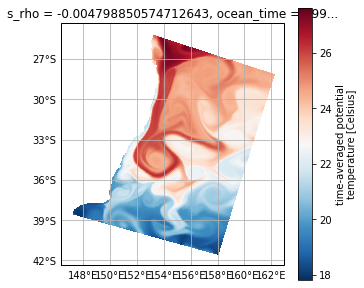

In [9]:
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ds.temp.sel(ocean_time='1994-01-31T12').isel(s_rho=-1).plot(ax=ax, transform=ccrs.PlateCarree(), 
                                        x='lon_rho', y='lat_rho', cmap='RdBu_r')
gl = ax.gridlines(draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = gl.ylabels_right = False

## Calculate heat advection

In [10]:
ds.u

<xarray.DataArray 'u' (ocean_time: 60, s_rho: 30, eta_rho: 317, xi_u: 271)>
dask.array<concatenate, shape=(60, 30, 317, 271), dtype=float32, chunksize=(30, 30, 317, 271), chunktype=numpy.ndarray>
Coordinates:
    lon_u       (eta_rho, xi_u) float64 dask.array<chunksize=(317, 271), meta=np.ndarray>
    lat_u       (eta_rho, xi_u) float64 dask.array<chunksize=(317, 271), meta=np.ndarray>
  * s_rho       (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
  * ocean_time  (ocean_time) datetime64[ns] 1994-01-01T12:00:00 ... 1994-03-01T12:00:00
Dimensions without coordinates: eta_rho, xi_u
Attributes:
    long_name:  time-averaged u-momentum component
    units:      meter second-1
    time:       ocean_time
    field:      u-velocity, scalar, series

In [17]:
ds['T_u'] = grid.interp(ds.u, axis='X', boundary = 'extend')*ds.temp
ds['T_v'] = grid.interp(ds.v, axis='Y', boundary = 'extend')*ds.temp

In [18]:
ds.T_u

<xarray.DataArray 'T_u' (ocean_time: 60, s_rho: 30, eta_rho: 317, xi_rho: 272)>
dask.array<mul, shape=(60, 30, 317, 272), dtype=float32, chunksize=(30, 30, 317, 270), chunktype=numpy.ndarray>
Coordinates:
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(317, 272), meta=np.ndarray>
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(317, 272), meta=np.ndarray>
  * s_rho       (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
  * ocean_time  (ocean_time) datetime64[ns] 1994-01-01T12:00:00 ... 1994-03-01T12:00:00
    z_rho       (ocean_time, s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(30, 30, 317, 272), meta=np.ndarray>
Dimensions without coordinates: eta_rho, xi_rho

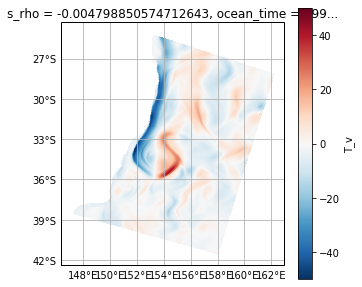

In [19]:
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ds.T_v.sel(ocean_time='1994-01-31T12').isel(s_rho=-1).plot(ax=ax, transform=ccrs.PlateCarree(), 
                                        x='lon_rho', y='lat_rho', cmap='RdBu_r')
gl = ax.gridlines(draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = gl.ylabels_right = False